In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1. Data downloading

In [2]:
import csv
import requests
from io import StringIO

# URL of the input file
input_url = "https://raw.githubusercontent.com/Benz-Poobua/ESS_523/main/HW1_GNSS_data.txt"

# Output file (CSV)
output_file = "GNSS_data.csv"

# Fetching data from URL
response = requests.get(input_url)

# Checking if request was successful
if response.status_code == 200:
    # Read the data from the response
    data = response.text

    # Read the data and write it to CSV
    with open(output_file, 'w', newline='') as outfile:
        # Create a CSV writer object
        writer = csv.writer(outfile)
        
        # Write the header row
        writer.writerow(["x_position(km)", "Surface_velocity(mm/yr)", "uncertainty(mm/yr)"])
        
        # Skip the header lines
        data_lines = data.strip().split('\n')[3:]
        
        # Write the data rows
        for line in data_lines:
            # Split the line based on whitespace
            columns = line.split()
            # Write the columns to CSV
            writer.writerow(columns)

    print("Data converted to CSV successfully. Converted data saved to", output_file)
else:
    print("Failed to retrieve data from the URL.")


Data converted to CSV successfully. Converted data saved to GNSS_data.csv


In [2]:
GNSS_data = pd.read_csv('https://raw.githubusercontent.com/Benz-Poobua/ESS_523/main/GNSS_data.csv')

In [3]:
GNSS_data

,x_position(km),Surface_velocity(mm/yr),uncertainty(mm/yr)
0,5.0,-26.8789,1.5905
1,20.0,-27.1257,0.8008
2,25.0,-27.4999,1.1438
3,70.0,-14.9070,2.6112
4,105.0,-5.9737,0.8839
5,185.0,18.3194,0.7195
6,200.0,19.0408,2.0715
7,208.0,21.6918,1.3580
8,220.0,25.0392,1.0329
9,290.0,28.7211,0.8648


### 2. Data visualization

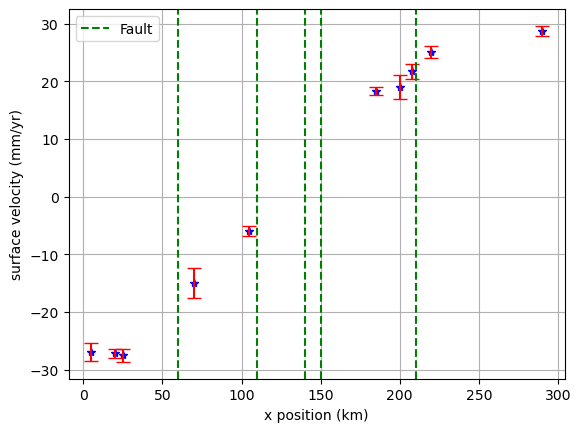

In [8]:
plt.plot(GNSS_data['x_position(km)'], GNSS_data['Surface_velocity(mm/yr)'], '*b')
plt.errorbar(GNSS_data['x_position(km)'],
             GNSS_data['Surface_velocity(mm/yr)'],
             yerr=GNSS_data['uncertainty(mm/yr)'], #y error bar
             fmt='none', # 'none' means no connecting lines
             ecolor='red', # color of the error bars
             capsize=5) # size of the caps on error bars
plt.xlabel('x position (km)')
plt.ylabel('surface velocity (mm/yr)')
plt.grid()

# Draw vertical red lines at specific x-axis positions
x_positions = [60, 110, 140, 150, 210]
for x in x_positions:
    plt.axvline(x, color='green', linestyle='dashed')

# Create a dummy plot for legend
plt.plot([], [], color='green', linestyle='dashed', label='Fault')

# Display legend
plt.legend()

plt.show()

### 3. Model equation

- $v(x_{\text{gnss}}, x_{\text{fault}}) = \frac{s}{\pi} \cdot \arctan \left( \frac{x_{\text{gnss}} - x_{\text{fault}}}{D} \right)$
- Goal is to solve for $s$, which is the interseismic slip rate



In [4]:
# data

d = GNSS_data['Surface_velocity(mm/yr)']

# Convert to NumPy array and reshape
d_matrix = d.values.reshape(-1, 1)

print(d_matrix)


[[-26.8789]
 [-27.1257]
 [-27.4999]
 [-14.907 ]
 [ -5.9737]
 [ 18.3194]
 [ 19.0408]
 [ 21.6918]
 [ 25.0392]
 [ 28.7211]]


In [5]:
x_gnss = GNSS_data['x_position(km)']
x_fault = [60, 110, 140, 150, 210]
locking_depth = [10, 10, 5, 15, 12]

# Initialize a 10x5 matrix filled with zeros
G = np.zeros((10, 5))

# Iterate over each element in the matrix
for i in range(10):
    for j in range(5):
        G[i, j] = np.arctan((x_gnss[i] - x_fault[j]) / locking_depth[j])

print(G)


[[-1.39094283 -1.47584462 -1.53377621 -1.46771472 -1.51232646]
 [-1.32581766 -1.46013911 -1.52915375 -1.45591972 -1.50772221]
 [-1.29249667 -1.45368758 -1.52734543 -1.4513674  -1.5060222 ]
 [ 0.78539816 -1.32581766 -1.49948886 -1.38544838 -1.48529103]
 [ 1.35212738 -0.46364761 -1.42889927 -1.24904577 -1.45700432]
 [ 1.49096634  1.43824479  1.46013911  1.16590454 -1.12327635]
 [ 1.49948886  1.46013911  1.48765509  1.27933953 -0.69473828]
 [ 1.5033313   1.46910748  1.497399    1.31772067 -0.16514868]
 [ 1.50837752  1.48013644  1.50837752  1.35970299  0.69473828]
 [ 1.52734543  1.51529782  1.53747533  1.46406065  1.42190638]]


### 4. SVD

- Use SVD
- Construct conpact form from $G = U S V^{T}$
- We use $ G^{-g} = V_p S_p^{-1} U_p^{-1}$


In [6]:
from scipy import linalg

In [7]:
U, S, VT = np.linalg.svd(G, full_matrices=True)

In [8]:
print(G.shape)
print(U.shape)
print(S.shape)
print(VT.shape)

(10, 5)
(10, 10)
(5,)
(5, 5)


In [9]:
S_2d = np.zeros((G.shape[0], G.shape[1]))
S_2d[:min(G.shape[0], G.shape[1]), :min(G.shape[0], G.shape[1])] = np.diag(S)

In [10]:
print(S_2d)
print(S_2d.shape)

[[8.76420345 0.         0.         0.         0.        ]
 [0.         3.75481577 0.         0.         0.        ]
 [0.         0.         1.96925538 0.         0.        ]
 [0.         0.         0.         0.39819278 0.        ]
 [0.         0.         0.         0.         0.03719986]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
(10, 5)


We then construct S_p, which is a square (p*p) diagonal matrix by delete the last sigular value closest to zero.

In [11]:
S_p = np.delete(np.delete(S_2d, slice(4, 10), axis=0), -1, axis=1) # delete rows 4 to 9 and then the last column
U_p = U[:, :4] # keep all rows and first to fourth columns
VT_p = VT[:4, :] 

In [12]:
print(U_p.shape)
print(S_p.shape)
print(VT_p.shape)

(10, 4)
(4, 4)
(4, 5)


### 5. Generalized Inverse

We calculate G^-g from $ G^{-g} = V_p S_p^{-1} U_p^{-1}$

In [13]:
V_p = VT_p.T # the first V is transposed 
S_p_i = np.linalg.inv(S_p) # do inverse
UT_p = U_p.T # do transpose

print(V_p.shape)
print(S_p_i.shape)
print(UT_p.shape)

(5, 4)
(4, 4)
(4, 10)


In [14]:
G_g = np.dot(V_p, np.dot(S_p_i, UT_p))
print(G_g.shape)

(5, 10)


In [15]:
print(G_g)

[[-1.11029873e-01 -9.85705736e-02 -9.12445030e-02  5.47188055e-01
  -6.56025933e-02 -4.48629419e-02 -2.73236342e-03  2.74468034e-02
   7.20463661e-02  1.15729162e-01]
 [ 9.52536302e-02  7.33442781e-02  5.82176586e-02 -1.64213866e+00
   1.34660360e+00  5.52590250e-02 -4.78353005e-02 -5.36897621e-02
  -3.87035441e-02 -6.44570720e-02]
 [-1.25976049e-02 -5.78234082e-03 -4.36576902e-04  6.93843971e-01
  -7.97255305e-01  9.63199008e-02  1.23337697e-01  9.16557765e-02
   2.71030295e-02 -5.35229295e-03]
 [-1.35721345e-02 -9.44331805e-03 -6.16178226e-03  4.25775466e-01
  -5.18582972e-01  6.20610816e-02  8.00003263e-02  6.07010219e-02
   2.10094224e-02  1.63175692e-03]
 [-1.15156172e-01 -1.11866561e-01 -1.10223889e-01 -1.44984416e-02
   5.24817518e-02 -2.14612030e-01 -1.64439815e-01 -9.51537424e-02
   1.88109073e-02  1.11215288e-01]]


### 6. Optimal model parameter

We use $m^{est} = G^{-g} d$

In [16]:
d_matrix = d.values.reshape(-1,1) # pandas series to numpy array and then reshape to a column matrix
m = np.dot(G_g, d)
print(m)

[5.25166347 6.40082598 1.552962   2.09106468 3.60204422]


Note that from the model, $G$ is unitless, so $m^{est}$ and $d$ have the same unit (mm/yr)

### 7. Covariance matrix

We note that $Cov(m^{est})$ = $G^{-g}Cov(d)(G^{-g})^T$, where
 
$$
\text{Cov}(d) = \begin{bmatrix}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_n^2
\end{bmatrix}
$$

In [17]:
cov_d = np.diag(GNSS_data['uncertainty(mm/yr)']**2)

In [18]:
print(G_g.shape)
print(cov_d.shape)
print(G_g.T.shape)

(5, 10)
(10, 10)
(10, 5)


In [19]:
cov_m = np.dot(np.dot(G_g, cov_d), G_g.T) 
print(cov_m)
print(cov_m.shape)

[[ 2.11120731e+00 -6.24605376e+00  2.63607659e+00  1.62271083e+00
   8.95826095e-03]
 [-6.24605376e+00  1.98555196e+01 -8.64337362e+00 -5.33865439e+00
   2.07042485e-01]
 [ 2.63607659e+00 -8.64337362e+00  3.86588805e+00  2.39407523e+00
  -2.10849469e-01]
 [ 1.62271083e+00 -5.33865439e+00  2.39407523e+00  1.48347175e+00
  -1.31274060e-01]
 [ 8.95826095e-03  2.07042485e-01 -2.10849469e-01 -1.31274060e-01
   2.27253489e-01]]
(5, 5)


### 8. Data and Model resolutions

- $R_m = V_p V_p^T$
- $R_d = U_p U_p^T$

In [20]:
R_m = np.dot(V_p, VT_p)
R_d = np.dot(U_p, UT_p)
print(R_m)

[[ 9.99820340e-01 -8.13131877e-04 -8.24476436e-03  1.05020223e-02
  -8.35185410e-04]
 [-8.13131877e-04  9.96319799e-01 -3.73154589e-02  4.75317142e-02
  -3.78001426e-03]
 [-8.24476436e-03 -3.73154589e-02  6.21639276e-01  4.81948616e-01
  -3.83275182e-02]
 [ 1.05020223e-02  4.75317142e-02  4.81948616e-01  3.86103119e-01
   4.88208559e-02]
 [-8.35185410e-04 -3.78001426e-03 -3.83275182e-02  4.88208559e-02
   9.96117465e-01]]


In [26]:
print(R_d)

[[ 2.27252303e-01  2.20768948e-01  2.17403522e-01 -4.75771433e-03
   8.44531604e-03  6.65903696e-02  1.64946330e-02 -4.47068978e-02
  -1.43946012e-01 -2.28223582e-01]
 [ 2.20768948e-01  2.14848258e-01  2.11793352e-01  1.32498981e-02
   1.57617107e-02  6.47256517e-02  1.63220141e-02 -4.30611138e-02
  -1.39402141e-01 -2.21192464e-01]
 [ 2.17403522e-01  2.11793352e-01  2.08912366e-01  2.40567615e-02
   1.85501851e-02  6.36791362e-02  1.62300309e-02 -4.22126283e-02
  -1.37074550e-01 -2.17565283e-01]
 [-4.75771433e-03  1.32498981e-02  2.40567615e-02  9.98170103e-01
  -8.80284505e-04 -2.01503829e-02  9.73604957e-03  1.25355562e-02
   1.02110931e-02  1.69297150e-02]
 [ 8.44531604e-03  1.57617107e-02  1.85501851e-02 -8.80284505e-04
   9.97412653e-01  1.12609602e-02 -1.80874758e-02 -6.14110906e-03
   2.29838675e-02  2.99345300e-02]
 [ 6.65903696e-02  6.47256517e-02  6.36791362e-02 -2.01503829e-02
   1.12609602e-02  4.66653238e-01  3.85201560e-01  2.75188968e-01
   9.46928630e-02 -5.09948848e-02

## Questions

1. Report the estimated slip rate and uncertainty

| Station | Estimated slip rate (mm/yr) | uncertainty^2|
| ------------- | ------------- | ------------- |
| 1  | 5.25166347  |2.11120731e+00|
| 2  | 6.40082598  |1.98555196e+01|
| 3  | 1.552962  |3.86588805e+00|
| 4  | 2.09106468  |1.48347175e+00|
| 5  | 3.60204422  |2.27253489e-01|

**Note:**     Diagonal elements that are close to 1 correspond to parameters for which we claim good resolution.

2. Which predicted data (GNSS stations) are best resolved? Which predicted data are least resolved?

station 1: 9.98170103e-01 (best)

station 9: 1.33903425e-01 (poor)

3. Which estimated model parameter is best resolved? Which estimated model parameter is least resolved?

fault 1: 9.99820340e-01 (best)

fault 4: 3.86103119e-01 (poor)


4. Calculate the predicted data using the optimal model paramters. Calculate the predicted GNSS velocity in 1 km steps across the fault.

In [33]:
x_new = np.arange(300)
x_fault = [60, 110, 140, 150, 210]
locking_depth = [10, 10, 5, 15, 12]

# Initialize a 10x5 matrix filled with zeros
G_pred = np.zeros((300, 5))

# Iterate over each element in the matrix
for i in range(300):
    for j in range(5):
        G_pred[i, j] = np.arctan((x_new[i] - x_fault[j]) / locking_depth[j])

print(G_pred)

[[-1.40564765 -1.48013644 -1.53509721 -1.47112767 -1.51371554]
 [-1.4029004  -1.47930931 -1.53484061 -1.47046322 -1.51344303]
 [-1.40006112 -1.47846699 -1.53458028 -1.46978988 -1.5131679 ]
 ...
 [ 1.52862725  1.51737128  1.53895995  1.46910748  1.43373015]
 [ 1.52880422  1.51765492  1.53916131  1.46978988  1.43526861]
 [ 1.52897971  1.51793556  1.53936015  1.47046322  1.43677313]]


In [40]:
v_pred = (np.dot(G_pred, m))/np.pi

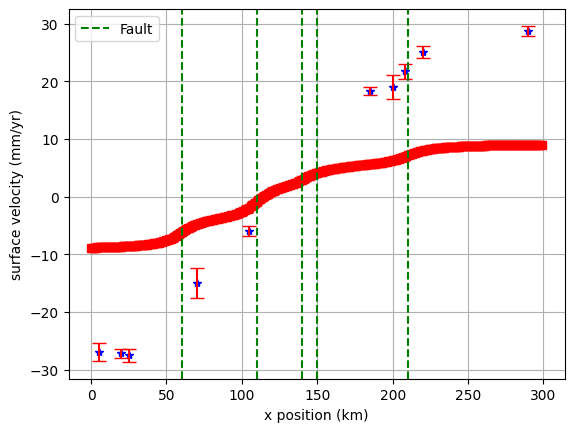

In [41]:
plt.plot(GNSS_data['x_position(km)'], GNSS_data['Surface_velocity(mm/yr)'], '*b')
plt.errorbar(GNSS_data['x_position(km)'],
             GNSS_data['Surface_velocity(mm/yr)'],
             yerr=GNSS_data['uncertainty(mm/yr)'], #y error bar
             fmt='none', # 'none' means no connecting lines
             ecolor='red', # color of the error bars
             capsize=5) # size of the caps on error bars
plt.plot(x_new, v_pred, 'sr')
plt.xlabel('x position (km)')
plt.ylabel('surface velocity (mm/yr)')
plt.grid()

# Draw vertical red lines at specific x-axis positions
x_positions = [60, 110, 140, 150, 210]
for x in x_positions:
    plt.axvline(x, color='green', linestyle='dashed')

# Create a dummy plot for legend
plt.plot([], [], color='green', linestyle='dashed', label='Fault')

# Display legend
plt.legend()

plt.show()